In [14]:
from langchain_community.document_loaders import DirectoryLoader, PyPDFLoader
from langchain_community.vectorstores import Pinecone
from langchain_pinecone import PineconeVectorStore
from pinecone import Pinecone as PC
from pinecone import ServerlessSpec
from langchain_text_splitters import RecursiveCharacterTextSplitter
import os
import glob
from sentence_transformers import SentenceTransformer
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.document_loaders import FileSystemBlobLoader
from langchain_community.document_loaders.generic import GenericLoader
from langchain_community.document_loaders.parsers import PyPDFParser
import time
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import uuid

In [15]:
#gerar n versoes da pergunta
#criar novos docs a partir do artigo, categorizados

In [13]:
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 18.9 MB/s eta 0:00:00 MB/s eta 0:00:0102
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.6 MB/s eta 0:00:00


In [16]:
loader = DirectoryLoader(
    "./rag-projeto/data",
    glob="*.pdf",
    loader_cls=PyPDFLoader
)

In [17]:
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # Tamanho máximo de cada pedaço
    chunk_overlap=50 # Sobreposição entre pedaços
)
docs_splitted = text_splitter.split_documents(docs)

texts = [doc.page_content for doc in docs_splitted]
#criar ID para rastrear os vetores
ids = [str(uuid.uuid4()) for _ in range(len(texts))]
#Apaga todos os vetores mas mantem o index criado
#index.delete(delete_all=True)

In [18]:

os.environ['PINECONE_API_KEY'] = 'pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST'


In [19]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(texts, show_porgress_bar=True)

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [20]:
index_name = "rag"
pc = PC(api_key="pcsk_6JsENF_EkUKdhWBGJXSsKsbKdU2E5HAuGGq8AvfAvaCjFYj2BJUBxgEPq9GHQYMk2wK6ST")
index = pc.Index(index_name)

In [21]:
embedder = HuggingFaceEmbeddings(
    model_name="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2", cache_folder="./ModeltoEmbedding"
)
#texts eh uma lista de strings onde cada string é um documento.Essa função gera os embeddings
embeddings= embedder.embed_documents(texts) 
# Associar os embeddings com seus IDs
vectors = [(ids[i], embeddings[i]) for i in range(len(embeddings))]
# Inserir os embeddings no Pinecone (upsert)
index.upsert(vectors=vectors)

#vectorstore = PineconeVectorStore.from_documents(docs_splitted, embedder, index_name=index_name)
index.describe_index_stats()


/tmp/ipykernel_43729/301720864.py:1: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedder = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

PineconeApiException: (400)
Reason: Bad Request
HTTP response headers: HTTPHeaderDict({'Date': 'Sun, 04 May 2025 03:28:08 GMT', 'Content-Type': 'application/json', 'Content-Length': '119', 'Connection': 'keep-alive', 'x-pinecone-request-latency-ms': '5254', 'x-pinecone-request-id': '8428295510020338810', 'x-envoy-upstream-service-time': '0', 'server': 'envoy'})
HTTP response body: {"code":11,"message":"Error, message length too large: found 15629406 bytes, the limit is: 4194304 bytes","details":[]}


In [22]:
query = "Principais Tipos de Diabetes"


#Funçao do pinecone que já realiza a busca
# similar_docs = vectorstore.similarity_search(query, k=5)
#função para pegar o embedding do query
query_embedding = embedder.embed_query(query)

In [23]:

#Resultado do metodo de busca padrao.
# similar_docs
print(index)


In [24]:
#Implementando uma busca personalizada
#Baseando-se na busca de similaridade por cosseno , para mais detalhes: https://pt.wikipedia.org/wiki/Produto_escalar
#Tem esse estudo falando sobre o problema deste método que é interessante: https://www.shaped.ai/blog/cosine-similarity-not-the-silver-bullet-we-thought-it-was
def cosine_similarity(v1, v2):
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# Calcular similaridade entre a consulta e todos os documentos
similarities = [cosine_similarity(query_embedding,doc_embedding) for doc_embedding in embeddings]
# Ordenar os índices dos documentos pela similaridade de forma decrescente
sorted_indices = np.argsort(similarities)[::-1]

# Obter os documentos mais semelhantes (top 5)
top_k = 100
top_docs = [texts[i] for i in sorted_indices[:top_k]]
top_similarities = [similarities[i] for i in sorted_indices[:top_k]]
top_embeddings = [embeddings[i] for i in sorted_indices[:top_k]]
# Exibir os resultados
for doc, sim in zip(top_docs, top_similarities):
    print(f"Similaridade: {sim:.4f}")
    print(f"Documento: {doc[:2000]}...")  # Exibir os primeiros 200 caracteres do documento
    print("-" * 50)


Similaridade: 0.7878
Documento: a fim de elucidar melhor estas relações. 
REFERÊNCIAS 
 
1. Borges DB, Lacerda JT. Ações voltadas ao controle do Diabetes Mellitus na 
Atenção Básica: proposta de modelo avaliativo. Saúde Debate. 2018; 42(116): 
162-178. Disponível em: http://www.scielo.br/pdf/sdeb/v42n116/0103-1104-
sdeb-42-116-0162.pdf 
2. International Diabetes Federation. IDF Atlas. 8º ed. Brussels, Belgium: 
International Diabetes Federation; 2017....
--------------------------------------------------
Similaridade: 0.7803
Documento:     Selvin E, Steffes MW, Gregg E, Brancati FL, Coresh J. Performance of A1C for
the classi cation and prediction of diabetes. Diabetes Care. 2011 Jan;34(1) 84-
9. doi: 10.2337/dc10-1235. 
    Kumar PR, Bhansali A, Ravikiran M, Bhansali S, Dutta P, Thakur JS, et al. Utility
of glycated hemoglobin in diagnosing type 2 diabetes mellitus: a community-
based study. J Clin Endocrinol Metab. 2010 Jun 1;95(6) 2832–5. 
    Kramer CK, Araneta MRG, Barrett-Connor 

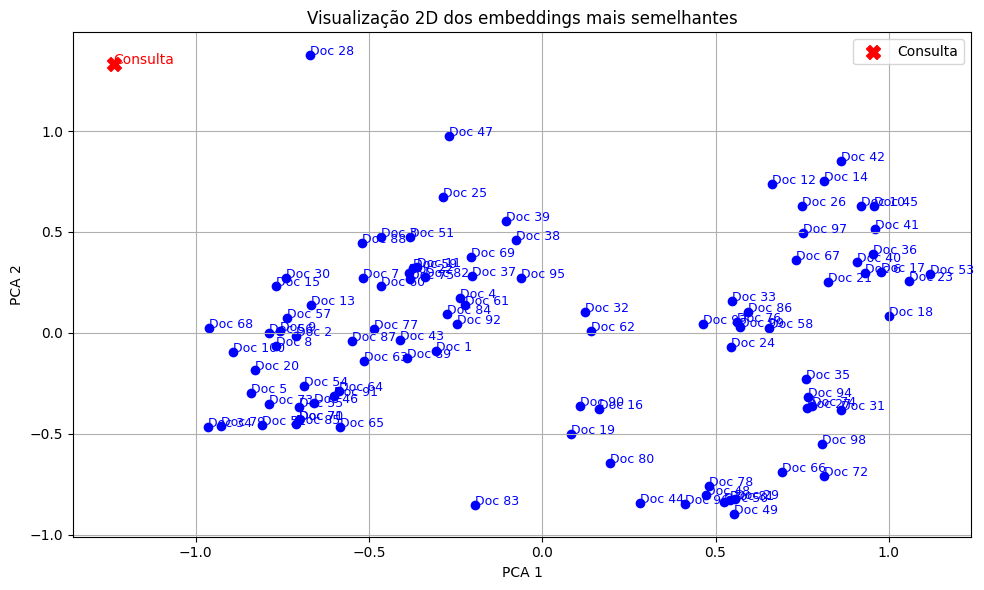

In [25]:
# Plotar os vetores em 2D com PCA
pca = PCA(n_components=2)
points_2d = pca.fit_transform(np.array(top_embeddings + [query_embedding]))

plt.figure(figsize=(10, 6))

# Plotar documentos
for i in range(top_k):
    plt.scatter(*points_2d[i], color='blue')
    plt.text(points_2d[i][0], points_2d[i][1], f'Doc {i+1}', color='blue', fontsize=9)

# Plotar consulta
plt.scatter(*points_2d[-1], color='red', marker='X', s=100, label='Consulta')
plt.text(points_2d[-1][0], points_2d[-1][1], 'Consulta', color='red', fontsize=10)

plt.title("Visualização 2D dos embeddings mais semelhantes")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()